***Install Dependencies***



In [1]:
!pip install -q transformers accelerate datasets scikit-learn \
matplotlib seaborn arabic-reshaper python-bidi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 39.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's de

***Imports***

In [ ]:
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed,
    EarlyStoppingCallback,
)

#ensures stablilty in diff. runs
set_seed(42)

#hardware checking
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#AraPoemBERT model
model_name = "faisalq/bert-base-arapoembert"
print(f"Model Selected: {model_name}")


2025-12-10 14:35:01.647782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765377301.827757      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765377301.874497      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda
Model Selected: faisalq/bert-base-arapoembert


***Cleaning Function***

In [ ]:
def advanced_clean(text):
    text = str(text)
    #remove Tashkeel (Diacritics)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    #remove Tatweel (Elongation)
    text = re.sub(r'ـ', '', text)
    #normalize Alef letter
    text = re.sub(r'[إأآ]', 'ا', text)
    #normalize Taa Marbuta letter
    text = re.sub(r'ة', 'ه', text)
    #normalize Yaa letter
    text = re.sub(r'ى', 'ي', text)
    #remove Numbers
    text = re.sub(r'\d+', '', text)
    #remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #remove extra Whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


***Load Dataset***

In [4]:
print("⬇ Loading dataset...")
dataset = load_dataset("omkarthawakar/FannOrFlop")

# Only keep the needed columns
df = dataset["train"].to_pandas()[["poem_verses", "era"]].dropna()

print("Applying Advanced Cleaning...")
print("Before:", df["poem_verses"].iloc[0][:80])
df["poem_verses"] = df["poem_verses"].apply(advanced_clean)
print("After :", df["poem_verses"].iloc[0][:80])

df.head()


⬇ Loading dataset...


README.md: 0.00B [00:00, ?B/s]

dataset.json:   0%|          | 0.00/99.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6984 [00:00<?, ? examples/s]

Applying Advanced Cleaning...
Before: 1

حَيّـاكُمُ اللَـهُ أَحيـوا العِلمَ وَالأَدَبا

إِن تَنشُروا العِلمَ يَنشُر في
After : حياكم الله احيوا العلم والادبا ان تنشروا العلم ينشر فيكم العربا ولا حياه لكم الا


,poem_verses,era
0,حياكم الله احيوا العلم والادبا ان تنشروا العلم...,العصر الحديث
1,غاب الاديب اديب مصر واختفي فلتبكه الاقلام او ت...,العصر الحديث
2,عثمان انك قد اتيت موفقا شروي سميك جامع التنزيل...,العصر الحديث
3,ان عضيك يا اخي بالملام لا يؤدي لمثل هذا الخصام...,العصر الحديث
4,من واجد منقر المنام طريد دهر جائر الاحكام مشتت...,العصر الحديث


***Split & Encode Labels***



In [ ]:
#encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["era"])

label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

print("Classes:", list(le.classes_))

#stratified train/validation split
train_df, val_df = train_test_split(
    df,
    test_size = 0.2, #this goes to val_df
    stratify = df["label"], #ensure class distribution is preserved
    random_state = 42,  #stability so every time we run code we get same split
)

print(f"Train size: {len(train_df)}")
print(f"Val size : {len(val_df)}")

train_df["label"].value_counts()

Classes: ['الدولة الايوبية', 'الدولة الفاطمية', 'الدولة المملوكية', 'الشعراء المخضرمون', 'العصر الأموي', 'العصر الإسلامي', 'العصر الحديث', 'العصر العباسي', 'العصر العثماني', 'المغرب والأندلس', 'عصر بين الدولتين', 'قبل الإسلام']
Train size: 5587
Val size : 1397


label
7     1874
6      560
4      454
9      357
0      330
1      327
2      326
3      307
11     299
8      261
10     257
5      235
Name: count, dtype: int64

***Balance Data (Upsampling)***

In [ ]:
print("Balancing training data (mild upsampling)...")
class_counts = train_df["label"].value_counts()
print("Before balance:\n", class_counts)

max_size = class_counts.max()
target_size = int(max_size * 0.7)  #setting the target size of the largest class to be 70% of the largest class 

balanced_parts = []

for label_id in train_df["label"].unique(): #lloping over each class
    subset = train_df[train_df["label"] == label_id]
    n = len(subset)

    if n < target_size: #if the class is smalller than target size
        #randoly duplicate samples with replacement
        upsampled = resample(
            subset,
            replace = True,
            n_samples = target_size,
            random_state = 42,
        )
        balanced_parts.append(upsampled)
    else:
        balanced_parts.append(subset) #class is already large enough > no change

train_df_balanced = pd.concat(balanced_parts) #combine into one df
train_df_balanced = train_df_balanced.sample(frac = 1, random_state = 42).reset_index(drop = True) #shuffle

print("After balance:\n", train_df_balanced["label"].value_counts())
print("Balanced train size:", len(train_df_balanced))


print("Balancing Training Data...")

Balancing training data (mild upsampling)...
Before balance:
 label
7     1874
6      560
4      454
9      357
0      330
1      327
2      326
3      307
11     299
8      261
10     257
5      235
Name: count, dtype: int64
After balance:
 label
7     1874
1     1311
3     1311
4     1311
11    1311
8     1311
6     1311
0     1311
5     1311
9     1311
10    1311
2     1311
Name: count, dtype: int64
Balanced train size: 16295


***Tokenization***

In [ ]:
print(f"Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 32
print("Using max length:", MAX_LEN)

def preprocess_function(examples):
    return tokenizer(
        examples["poem_verses"],
        truncation = True,
        max_length = MAX_LEN,
    )

print("Tokenizing data...")
train_ds = Dataset.from_pandas(train_df_balanced)
val_ds = Dataset.from_pandas(val_df)
#apply tokenization
train_ds = train_ds.map(preprocess_function, batched = True)
val_ds = val_ds.map(preprocess_function, batched = True)

#remove/ clean columns not needed - era already encoded as label :)
def clean_columns(ds):
    cols_to_remove = [c for c in ["era", "__index_level_0__"] if c in ds.column_names]
    if cols_to_remove:
        ds = ds.remove_columns(cols_to_remove)
    return ds

train_ds = clean_columns(train_ds).with_format("torch")
val_ds = clean_columns(val_ds).with_format("torch")

train_ds

Loading tokenizer: faisalq/bert-base-arapoembert
Using max length: 32
Tokenizing data...


Map:   0%|          | 0/16295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1397 [00:00<?, ? examples/s]

Dataset({
    features: ['poem_verses', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16295
})

***Initialize Model***

In [ ]:
print("Initializing Model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = len(le.classes_), #12 classes
    id2label = id2label, #map classes to num IDs
    label2id = label2id, #map num IDs to classes
)

#using moderate dropout 
model.config.hidden_dropout_prob = 0.1
model.config.attention_probs_dropout_prob = 0.1
if hasattr(model.config, "classifier_dropout") and model.config.classifier_dropout is not None:
    model.config.classifier_dropout = 0.1

model.to(device)
print("Model ready.")


Initializing Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at faisalq/bert-base-arapoembert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model ready.


***Training Setup***

In [ ]:
#computing the metrics: Accuracy & F1 Score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir="./arapoembert_tuned_results", #path where checkpoints and logs are saved

    #evaluation strategy - each happens per epoch
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",

    #optimization tuning
    learning_rate = 2e-5, #common learning rate for BERT 
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 32,
    gradient_accumulation_steps = 1,

    num_train_epochs = 8, #8 passes over training data
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1, #10% of training steps increse lineraly to lr ,, stable at early point

    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    report_to = "none",
)

trainer = Trainer(
    model = model, #AraPoemBERT
    args = training_args, #all hyperparameters and strategies written above :)
    train_dataset = train_ds, #tokanized dataset
    eval_dataset = val_ds, #tokanized dataset
    tokenizer = tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer), #pad each batch to max length dynamically
    compute_metrics=compute_metrics, #compute metrics after each eval
)

/tmp/ipykernel_47/2359072619.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


***Train Model***

In [15]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.155800,1.789117,0.348604,0.347776
2,1.230500,1.637266,0.435934,0.444751
3,0.543000,1.753695,0.498926,0.488658
4,0.204300,2.080380,0.481031,0.470689
5,0.081400,2.420966,0.512527,0.491673
6,0.037100,2.732583,0.503937,0.485661
7,0.019400,2.877211,0.511811,0.492725
8,0.015400,2.894384,0.503937,0.488323


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=4080, training_loss=0.5358422406748229, metrics={'train_runtime': 819.2174, 'train_samples_per_second': 159.127, 'train_steps_per_second': 4.98, 'total_flos': 1789083399813120.0, 'train_loss': 0.5358422406748229, 'epoch': 8.0})

***Evaluate and Visualize***


Final Report :


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


                   precision    recall  f1-score   support

  الدولة الايوبية      0.366     0.313     0.338        83
  الدولة الفاطمية      0.341     0.171     0.228        82
 الدولة المملوكية      0.590     0.439     0.503        82
الشعراء المخضرمون      0.375     0.355     0.365        76
     العصر الأموي      0.590     0.518     0.551       114
   العصر الإسلامي      0.211     0.136     0.165        59
     العصر الحديث      0.768     0.521     0.621       140
    العصر العباسي      0.557     0.818     0.663       468
   العصر العثماني      0.449     0.338     0.386        65
  المغرب والأندلس      0.470     0.348     0.400        89
 عصر بين الدولتين      0.419     0.281     0.336        64
      قبل الإسلام      0.260     0.253     0.257        75

         accuracy                          0.513      1397
        macro avg      0.450     0.374     0.401      1397
     weighted avg      0.501     0.513     0.492      1397



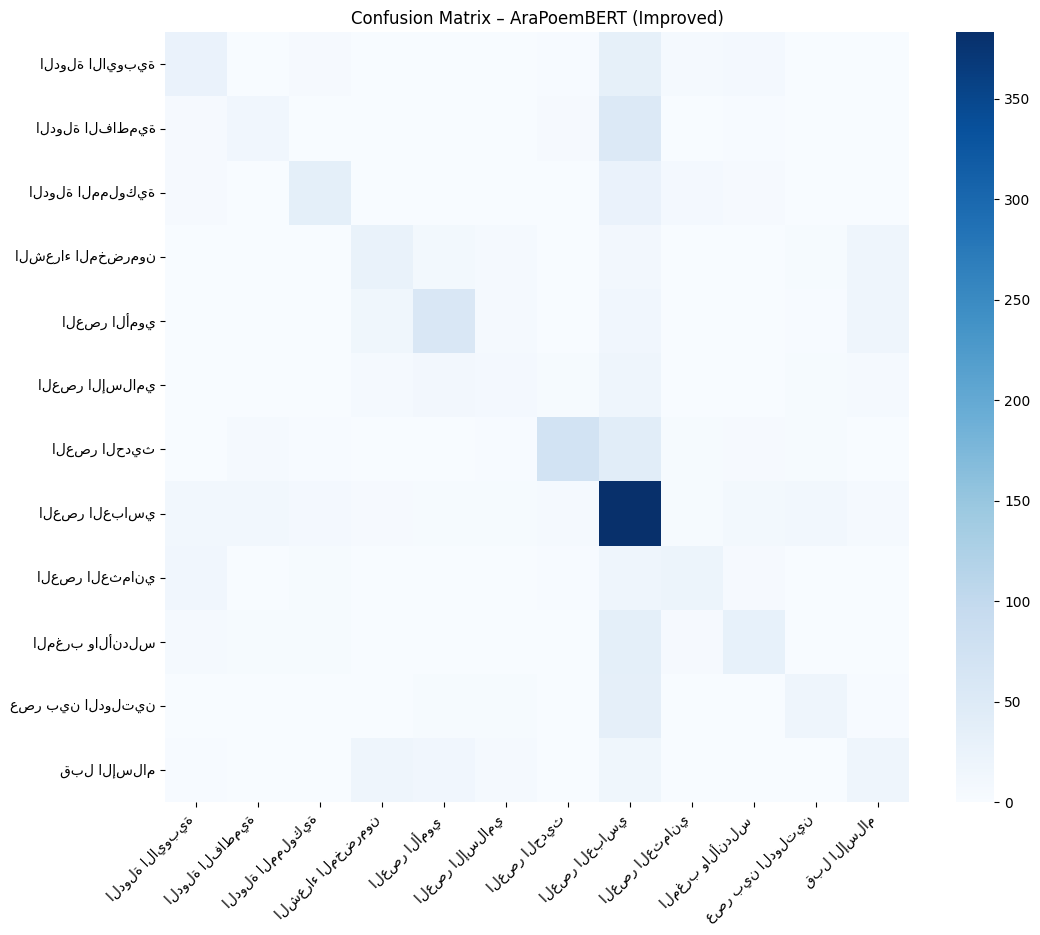

In [ ]:
print("\nFinal Report :")
pred_output = trainer.predict(val_ds)
#prediction is in shape of (samples, 12) and converted to argmax(axis=1)
#which means selecting class with highest score
y_pred = np.argmax(pred_output.predictions, axis = 1)
y_true = pred_output.label_ids

#printing text report
print(classification_report(y_true, y_pred, target_names = le.classes_, digits = 3))

#visualizing Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsiz = (12, 10))
sns.heatmap(
    cm,
    annot = False,
    cmap = "Blues",
    xticklabels = le.classes_,
    yticklabels = le.classes_,
)
plt.title("Confusion Matrix – AraPoemBERT (Improved)")
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.show()


***Save Model and Tokenizer***

In [17]:
save_dir = "./arapoembert_ultimate_final"
print(f"Saving model to {save_dir} ...")
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("Done.")


Saving model to ./arapoembert_ultimate_final ...
Done.
